In [1]:
# 한글깨짐
import platform
import matplotlib.pyplot as plt

os = platform.system()

# Windows
if os == 'Windows':
    plt.rc('font', family= 'Malgun Gothic')

else:
    print(f'{os} is not set')

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
rc('font', family = 'Malgun Gothic')
rc('axes', unicode_minus = False)

import pandas as pd
from konlpy.tag import Mecab
from emoji import core
from gensim import corpora, models
from collections import Counter
import re
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
mecab = Mecab(dicpath=r"C:/mecab/mecab-ko-dic")

file_path ='best_real_last_reviews_with_group_help_ox.csv'
df = pd.read_csv(file_path)
df['help_cnt_yes']=df['help_cnt'].apply(lambda x:0 if x == 0 else 1)
df=df[(df['help_cnt_yes']==1) & (df['predicted_class']==0)] # 도움 1 & 부정
df['review']=df['review'].str.replace(" +", " ")


def load_stopwords(filepath):
    with open(filepath, 'r', encoding='cp949') as file:
        stopwords = file.read().strip().split(',')
        return set(stopwords)
    
def clean_text(text):
  text= core.replace_emoji(text,replace='')
  text=re.sub(r'[^가-힣0-9\.]',' ',text) # 알파벳, 숫자, 마침
  text=re.sub(r'\.+','.',text) # 연속된 마침표
  text=re.sub(r'\n',' ',text) # 줄바꿈 문자
  text=re.sub(r'^[.]|[.]$',' ',text)

  return text.strip()

def remove_stopwords(text, stopwords):
    words = text.split()  # 텍스트를 공백 기준으로 분할
    filtered_words = [word for word in words if word not in stopwords]  # 불용어 제거
    return ' '.join(filtered_words)
    
stopwords = load_stopwords('../data/stopwords.txt')

df['review']=df['review'].apply(clean_text)

df['review']=df['review'].apply(lambda x : remove_stopwords(x,stopwords))

In [4]:
tokenized_docs = [mecab.pos(review) for review in df['review']]
tokenized_docs = [[word[0] for word in doc 
                   if word[0] not in stopwords and len(word[0]) > 1 and (word[0] not in ['생각','구매','신발','유면','원대', '대부분', '애용','해용', '산거','신한','신음','다운','일가','만한','이만', '애신','이용','응기','행력','은지','경우','해유','나용','니더', '구여','이면','여요','애요','아이오']) 
                   and (word[1] in ('NNG','VA','XR','SL')) ] for doc in tokenized_docs]

token_counts = Counter(word for doc in tokenized_docs for word in doc)
token_df = pd.DataFrame(token_counts.items(), columns=['Morpheme', 'Frequency'])

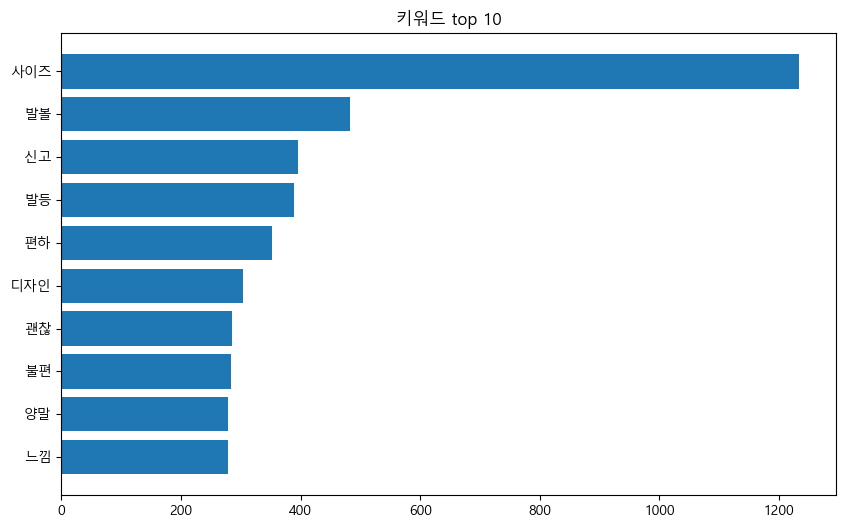

In [5]:
sort_token=token_df.sort_values(by='Frequency',ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.barh(sort_token['Morpheme'],sort_token['Frequency'])
plt.title('키워드 top 10')
plt.gca().invert_yaxis() #y축 반전
plt.show()

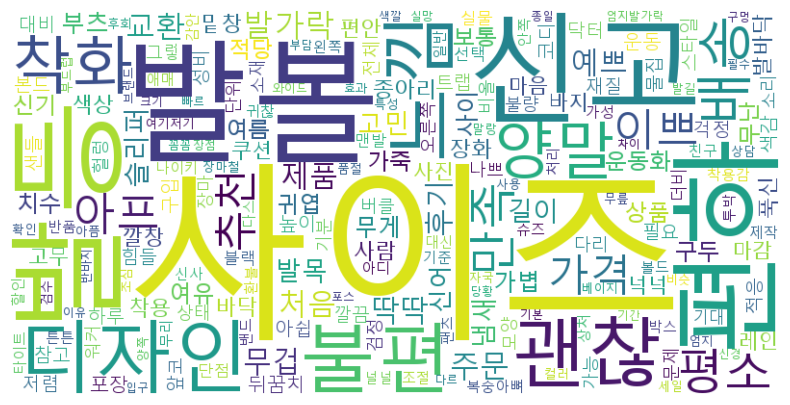

In [6]:
font_path='C:/Windows/Fonts/malgun.ttf'
# 워드클라우드 객체 생성
wordcloud = WordCloud(font_path=font_path, width = 800, height = 400, background_color ='white').generate_from_frequencies(token_counts)

# 워드클라우드 보여주기
plt.figure(figsize=(10, 5))  # 크기 조정
plt.imshow(wordcloud, interpolation="bilinear")  # 이미지 표시
plt.axis("off")  # 축 제거
plt.show()

In [7]:
id2word = corpora.Dictionary(tokenized_docs)
corpus = [id2word.doc2bow(doc) for doc in tokenized_docs]
columns_as_lists = tokenized_docs

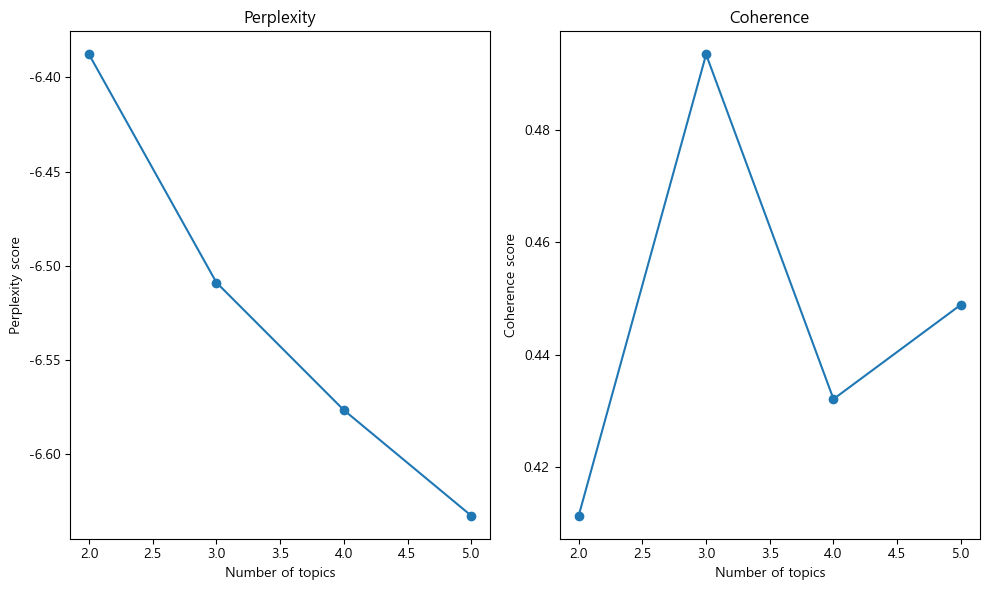

In [8]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt


start_topic =2
end_topic = 5
step = 1
topic_range = range(start_topic, end_topic + 1, step)

# Perplexity 계산
perplexity_values = []
for i in topic_range:
    
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word=id2word)
    perplexity_values.append(ldamodel.log_perplexity(corpus)) 

# Coherence 계산
coherence_scores = []
for i in topic_range:
    lda_model = LdaModel(corpus, num_topics=i, id2word=id2word, passes=15)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=columns_as_lists, dictionary=id2word, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_score)


fig, axes = plt.subplots(1, 2, figsize=(10, 6))
x = topic_range
plt.rcParams['axes.unicode_minus'] = False

# Perplexity subplot
axes[0].plot(x, perplexity_values, marker='o')
axes[0].set_xlabel('Number of topics')
axes[0].set_ylabel('Perplexity score') 
axes[0].set_title('Perplexity') 


# Coherence subplot
axes[1].plot(topic_range, coherence_scores, marker='o')
axes[1].set_xlabel('Number of topics')
axes[1].set_ylabel('Coherence score')
axes[1].set_title('Coherence')


plt.tight_layout()
plt.show()

In [9]:
optimal_co = topic_range[coherence_scores.index(max(coherence_scores))]
print("최적토픽 수 : ", optimal_co) # 7

최적토픽 수 :  3


In [10]:
lda_model = models.LdaModel(corpus, # 말뭉치
                            num_topics=optimal_co, # 최적의 주제수 # 최적의 주제수 7개가  나왔지만..
                            id2word=id2word, # 단어사전
                            #chunksize=20, # 각 학습 단계에서 사용하는 문서의 수
                            #passes=15, # 말뭉치 반복 횟수
                            #iterations=100, # 각 문서에 대해 LDA 모델 반복 횟수
                            per_word_topics=True) # 각 단어에 대한 토픽 정보 저장

In [11]:
for topic_id, topic_words in lda_model.print_topics():
    print(f"Topic {topic_id}: {topic_words}") # 키워드 가중치, 키워드

Topic 0: 0.032*"사이즈" + 0.025*"발등" + 0.021*"불편" + 0.019*"신고" + 0.019*"착화" + 0.017*"교환" + 0.017*"느낌" + 0.016*"발볼" + 0.015*"발가락" + 0.014*"슬리퍼"
Topic 1: 0.030*"사이즈" + 0.021*"디자인" + 0.017*"편하" + 0.017*"신고" + 0.016*"만족" + 0.015*"이쁘" + 0.014*"착화" + 0.014*"가격" + 0.013*"제품" + 0.013*"양말"
Topic 2: 0.081*"사이즈" + 0.039*"발볼" + 0.022*"발등" + 0.017*"편하" + 0.016*"신고" + 0.014*"아프" + 0.013*"괜찮" + 0.013*"주문" + 0.011*"평소" + 0.011*"처음"


In [12]:
# dominant topic and its percentage contribution in each document

def topic_sentences(ldamodel=None, corpus=None, texts=None, df=None):
    topic_list = []

    # 문서별 토픽 할당
    for n in range(len(corpus)):
        doc_topic = ldamodel.get_document_topics(corpus[n], minimum_probability=0.0)
        doc_topic = sorted(doc_topic, key=lambda x: x[1], reverse=True)
        topic_most_pr = doc_topic[0][0]
        topic_pr = doc_topic[0][1]
        
        # 키워드 추출
        wp = ldamodel.show_topic(topic_most_pr)
        topic_keywords = ", ".join([word for word, prop in wp])
        
        topic_list.append([n, topic_most_pr, topic_pr, topic_keywords])
    
  
    topic_df = pd.DataFrame(topic_list, columns=['document_num', 'Dominant_Topic', 'Percentage', 'Keywords'])
    topic_df = topic_df.set_index('document_num')
    
    
    df = df.reset_index(drop=True)
    result_df = topic_df.join(df[['review']], how='inner')

    # 옵션 설정: 최대 컬럼 너비
    pd.set_option('display.max_colwidth', 1000)

    return result_df.reset_index(drop=True)


topic_df = topic_sentences(ldamodel=lda_model, corpus=corpus, texts=df['review'], df=df)

topic_df.head()

,Dominant_Topic,Percentage,Keywords,review
0,1,0.536471,"사이즈, 디자인, 편하, 신고, 만족, 이쁘, 착화, 가격, 제품, 양말",치마 원피스 바지에 무난하게 잘 어울려서 코디 하기 좋아요 신고 벗기가 편하고 고리로 걸거나 찍찍이 선호 하지 않는 분에게 매우매우 추천합니다 신발이 전체적으로 둥글한 느낌이 있어서 발 큰 사람한테 좋을듯
1,2,0.652272,"사이즈, 발볼, 발등, 편하, 신고, 아프, 괜찮, 주문, 평소, 처음",좋아욥 궈여워요 그치만 발에 땀이 나면 곤란해요
2,1,0.859298,"사이즈, 디자인, 편하, 신고, 만족, 이쁘, 착화, 가격, 제품, 양말",여름용 딱입니다 디자인 도 튀지 않고 무난하지더 않아서 어디에 신던 좋아요 발이 커보이는 디자인인 점과 한 세번째 신었는데 발등이 까져서 별4개입니다
3,1,0.957687,"사이즈, 디자인, 편하, 신고, 만족, 이쁘, 착화, 가격, 제품, 양말",어. 제가 버클있는 샌들을 안 좋아해서 샌들 카테고리를 보다가 신발을 보고는 마음에 들어서 구매했는데요. 사이즈도 낙낙하고 착화감도 편해서 한달동안 잘 신고 다녔는데. 양말 안신어도 이쁘고 양말 신어도 이쁘고 그랬는데. 봤는데 밑창이 갈라져있네요. 분들도 그런가요. 신발은 디자인이랑 다 맘에드는데. 내구성 무슨일. 제가 신발을 험하게 신는편도 아닌데 놀랐어요.허허
4,2,0.788552,"사이즈, 발볼, 발등, 편하, 신고, 아프, 괜찮, 주문, 평소, 처음",신발 이쁨. 배송도 주문제작이라 오래걸릴거 감안한거 치고 금방왔고 마감이 깔끔하고 이쁩니다 오래신을거 같은.아니 오래 못신으면 한켤레 더살정도. 이게 위에 끈으로 발을 잡아주는거라서 좋으면서도 양말신고 신기엔 빠듯한감이 있으니 반업하는거 추천합니당


In [13]:
# topic 별 가장 대표하는 review
representative_sen=topic_df.groupby('Dominant_Topic')['Percentage'].idxmax()

topic_df.loc[representative_sen]

,Dominant_Topic,Percentage,Keywords,review
2064,0,0.980690,"사이즈, 발등, 불편, 신고, 착화, 교환, 느낌, 발볼, 발가락, 슬리퍼",디자인이 이뻐서 주문을 하였는데 상품에 결함이 있습니다 오른쪽 끈 잘 보시면 검은색 선이 그려져 있는데 아마 밑창 안 들어가야 하는 경계선인 거 같습니다 왼쪽과 비교하면 이해하실 겁니다 처음에 받았을 때는 이쁘고 편해서 좋았는데 외출을 해보니깐 오른쪽이 유독 헐렁하고 자주 엇나가는 느낌을 받았습니다 저는 걸음걸이가 문제라고 생각해서 똑바로 걷고 신경쓰며 걸었는데 자꾸 신발이 벗어나고 불편함을 겪었습니다 걸음걸이가 문제인건가 싶어서 스트레스를 받았었는데 집에 돌아오는 길에도 똑같이 신발이 헐렁하고 불편함을 느껴 도대체 문제인가 자세히 들여다보니 오른쪽 발가락 사이 끈 부분이 왼쪽에 비해 헐렁하게 제조가 되어 있었다는 걸 알았습니다 결함인 같은데. 앞으로 자주 신을 생각이었는데 상태로는 신을 수도 없고 불편함만 겪을 거 같습니다 마감처리가 되게 아쉬운 부분이네요. 환불이나 교환이 가능한지 문의드립니다
45,1,0.980985,"사이즈, 디자인, 편하, 신고, 만족, 이쁘, 착화, 가격, 제품, 양말",고무라 발쪽에 땀차서 불편하지않을까했는데 안쪽에는 천으로 잘 마감되어있어 보송보송하고 좋았어요. 찐여름 장마가 안와서 그런거일수도있겠지만 색감은 첫번째사진이 보여주는정도고 아주 사알짝 탁한 느낌이 있습니다. 사이즈는 전 보통 235 240 칼발이라 크게 사면 더무겁고 허덕이게될거같아 정사이즈로 딱맞게 구매했습니다. 비오는날 기분이 좋아진다는거부터 삶의 질이 달라지는 기분이에요. 남들은 걸으며 양말에 한껏먹힌 물을 뿜어낼때 발은 극강의 뽀송함입니다 잘샀다 생각한 이유중 하나에요 레인부츠가 하나도 없으시다면 장만하세요 언넝 크나큰 단점을 미끄러워요. 제경험상 젖은곳 젖은신발은 괜찮은데. 마른곳 젖은레인부츠 만나닌까 미끄러운거 같더라고요. 후기에서 한번도 못봤는지.아무리 고무라고해도. 레인부츠가 미끄러우면 살인미수 아닌지. 지하철 내려가는 마른계단에서 공중에 날라서 꼬리뼈 아작나는줄 알았습니다. 조심하세요
559,2,0.982715,"사이즈, 발볼, 발등, 편하, 신고, 아프, 괜찮, 주문, 평소, 처음",케즈 처음이라 후기 결정했는데 하루 종일 신었는데 편하고 까지는 곳 베기는 곳 없었어요. 평소 정사이즈 작거나 큰 적 없는 평범한 발에 편안하게 맞는 편이고 덧신이나 양말신고 작다는 느낌 없네요. 덧신 양말 신고 신발신으니 신은 표가 안나게 감쪽같이 가려져서 맨발로 안신어도 되어 좋네요. 사진도 덧신 신은 채 신발신은 거예요. 스커트나 쇼츠에 양말신고 신으면 귀엽고 무난한 건 물론이고 어중간한 길이의 팬츠에 발등 덮이는 거 신으면 답답해보여서 개방감있고 편한 무드로 요거 활용하기 좋네요. 사진도 어중간한 발목 기장의 슬랙스에 착장요. 세련된 느낌은 사실 없어요. 편하고 귀엽고 무난해 활용도가 괜찮다는 수준요


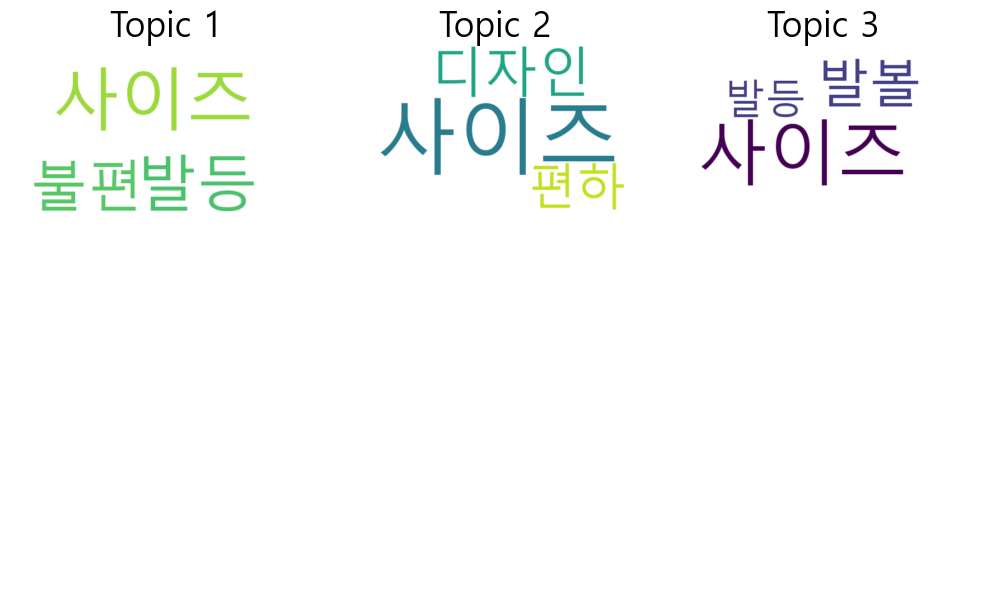

In [14]:
topic_df = topic_sentences(ldamodel=lda_model, corpus=corpus, texts=df['review'], df=df)

# 토픽별 워드 클라우드 생성( 가중치 시각화)
fig, axes = plt.subplots(3, 3, figsize=(10, 6), sharex=True, sharey=True)
wordcloud = WordCloud(font_path=font_path,width=500, height=300, background_color='white')

for i, ax in enumerate(axes.flatten()):
    if i >= len(lda_model.get_topics()): 
        ax.axis('off')
        continue

    fig.add_subplot(ax)
    topic_words = dict(lda_model.show_topic(i, topn=3))  # 각 토픽의 상위 3개 키워드 사용
    wordcloud.generate_from_frequencies(topic_words)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title('Topic ' + str(i+1), fontdict=dict(size=25))
    ax.axis('off')

plt.tight_layout()
plt.show()

C:\Users\jk032\AppData\Local\Temp\ipykernel_24420\3904257.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='viridis', ax=ax)


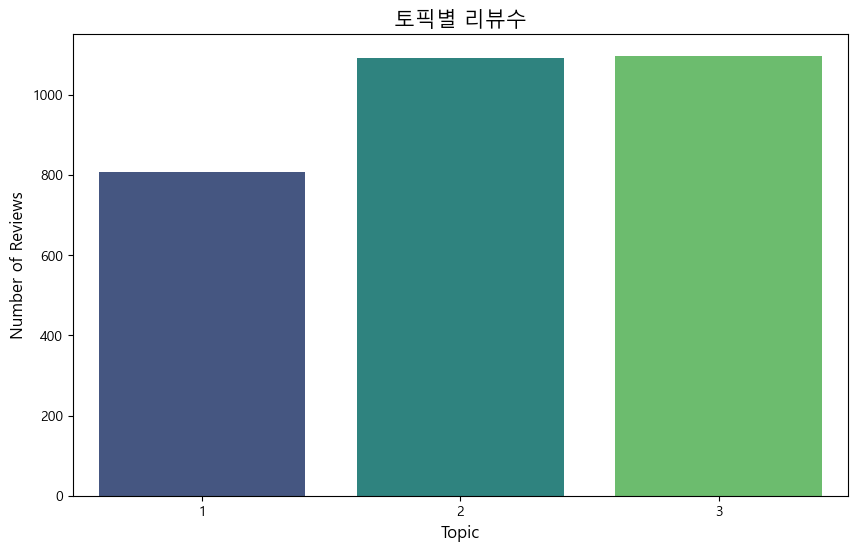

In [15]:
topic_df = topic_sentences(ldamodel=lda_model, corpus=corpus, texts=df['review'], df=df)

# 토픽별 리뷰 수
topic_counts = topic_df['Dominant_Topic'].value_counts().sort_index()

# 막대 차트 시각화
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='viridis', ax=ax)
ax.set_title('토픽별 리뷰수', fontsize=15)
ax.set_xlabel('Topic', fontsize=12)
ax.set_ylabel('Number of Reviews', fontsize=12)

ax.set_xticks(range(len(topic_counts)))
ax.set_xticklabels(range(1, len(topic_counts) + 1))

plt.xticks(rotation=0)
plt.show()

In [16]:
#pyLDA
vis = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis,local=False)

In [17]:
pyLDAvis.save_html(vis, 'lda_visualization_help1neg.html')
# file:///C:/Users/jk032/zerobase/mlproject/lda_visualization_help1neg.html